<h1 align="center"> Geometric Methods in ML - ENSAE 2016/2017 </h1>
<h2 align="center"> Kernels approximation with Random Features </h2>
<h4 align="right"> <i>Author: Hicham Janati </i></h4>


In this notebook, we adapt the <a href="https://github.com/felixyu/SRF"> Matlab code </a> provided by Felix Yu as two Python classes.
- **KernelApprox:** (Previous Notebook) approximates the kernel function by a kernel verifying Bochner theorem assumptions and yields an empirical sampling distribution p. 
- <font color="red">**SRFF:** </font> Spherical Random Fourier Features object performing the low-dimensional embedding given the sampling distribution p.

After generating the sampling distribution, now we can create the random features Z and approximating the data kernel. 

In [34]:
import numpy as np # Thinly−wrapped numpy
import pandas as pd
from math import factorial
%matplotlib inline 
from matplotlib import pyplot as plt 
import matplotlib as mpl
data = '../data/'
from sklearn.base import BaseEstimator
from sklearn.exceptions import NotFittedError


Import the KernelApprox Class implemented in <a href=""> SRF - Polynomial Kernel - Implementation I </a> 

In [12]:
from KernelApprox import*

We implement now a similar class to that in the introduction notebook <a href=""> RFF - Implementation </a> except that SRFF samples from an empirical distribution estimated by an instance of ApproxKernel. 

In [41]:
import numpy as np # Thinly−wrapped numpy
from sklearn.base import BaseEstimator
from sklearn.exceptions import NotFittedError

class SRFF(BaseEstimator):
    def __init__(self, cdf, a = 2, p = 20, D = 500):
        self.cdf = cdf
        self.a = a
        self.p = p
        #D (number of MonteCarlo samples)
        self.D = D
        self.fitted = False
        
    def random_sample(self):
        R = np.zeros(self.D)
        for i in range(self.D):
            R[i] = max(i for r in [np.random.random()] for i,c in self.cdf if c <= r)
    
        return R.reshape(self.D,1)
    
    def fit(self, X, y=None):
        """ Generates MonteCarlo random samples """
        dim = X.shape[1]
        #Generate D iid samples from p(w) 
        self.w = self.random_sample()
        self.gauss = np.random.randn(self.D,dim)
        w_normalization = np.sqrt((self.gauss**2).sum(axis=1))
        self.gauss /= w_normalization.reshape(-1,1)
        
        self.w = np.repeat(self.w, dim, axis = 1) * self.gauss
        #Generate D iid samples from Uniform(0,2*pi) 
        self.u = 2*np.pi*np.random.rand(self.D)
        self.fitted = True
        return self
    
    def transform(self,X):
        """ Transforms the data X (n_samples, n_features) to the new map space Z(X) (n_samples, n_components)"""
        if not self.fitted:
            raise NotFittedError("RBF_MonteCarlo must be fitted beform computing the feature map Z")
        #Compute feature map Z(x):
        Z = np.sqrt(2/self.D)*np.cos(X.dot(self.w.T) + self.u[np.newaxis,:])
        return Z
    
    def compute_kernel(self, X):
        """ Computes the approximated kernel matrix K """
        if not self.fitted:
            raise NotFittedError("RBF_MonteCarlo must be fitted beform computing the feature map Z")
        Z = self.transform(X)
        K = Z.dot(Z.T)
        return K
    

# Simulation: 

#### Let's approximate polynomial kernel matrices on random data. For A = 4 and degree = 10, first generate the correspondant CDF. 

In [19]:
from time import time

EPS, GRID_SIZE = 1e-20, 500
A, P = 4, 10
def polynomial_kernel_scalar(z, a = A, degree = P):
    return (1- (z/a)**2)**degree

Kapp = KernelApprox(dim = DIM, kernelfunc = polynomial_kernel_scalar, eps = EPS, grid_size=GRID_SIZE, N = 10)
t = time()
Kapp.fit(eval_grid_factor=2)
t = time() - t
cdf = Kapp.get_cdf()
print("Approximation time: %.2f" %t)

Launching L-BFGS ...
Converged.
Estimating PDF and Kernel approximation on the given grid ...
Done.
Approximation time: 5.46


#### Before drawing from the cdf, we must evaluate the quality of the approximation because it depends on the random initialization ...

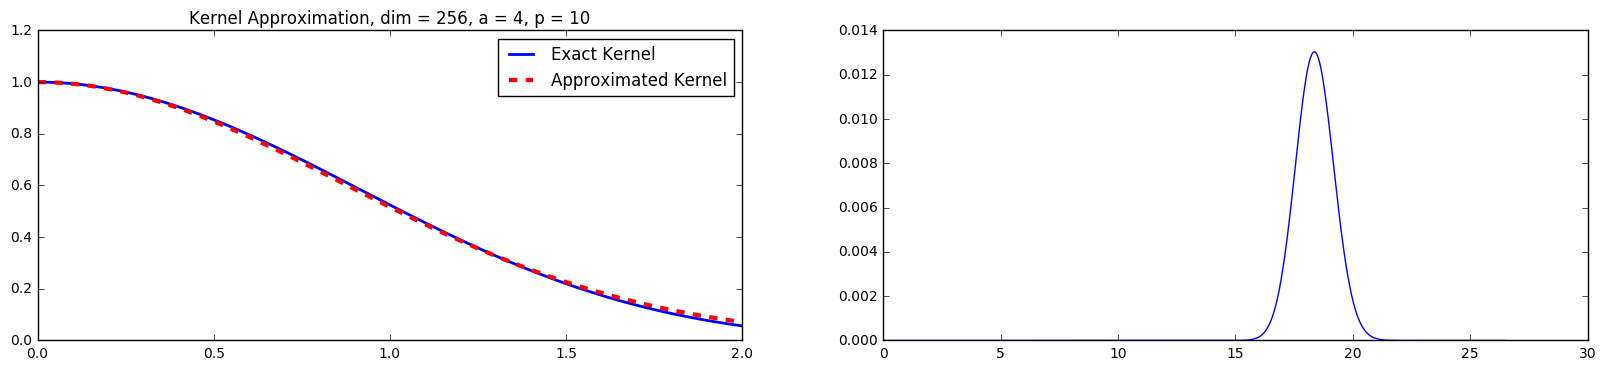

In [20]:
z = np.linspace(0,2,2*GRID_SIZE)
plt.figure(figsize=(20,4))
plt.subplot(121)
plt.plot(z,polynomial_kernel_scalar(z),linewidth=2, label = "Exact Kernel")
plt.plot(z,Kapp.get_kernel_approx(),'r--',linewidth=3, label = "Approximated Kernel")
plt.title("Kernel Approximation, dim = {}, a = {}, p = {}".format(DIM,A,P))
plt.legend()
plt.subplot(122)
wmax = Kapp.get_cdf()[-1][0]
w = np.linspace(0,wmax,2*GRID_SIZE)
plt.plot(w,Kapp.get_pdf())
plt.show()

In [31]:
from sklearn.metrics.pairwise import  polynomial_kernel

#size of data
N_SAMPLES, DIM = 1000, 200 
X = np.random.randn(N_SAMPLES,DIM)
Xnorm = X/np.sqrt((X**2).sum(axis=1)).reshape(-1,1)

#Number of monte carlo samples D
Ds = np.arange(1,5000,200)

gamma = 2/A**2
coef0 = 1 - gamma

t = time()
K_exact = polynomial_kernel(Xnorm, gamma=gamma, degree=P, coef0=coef0)
t_exact = time() -t 

n_repeats = 1
errors = np.empty((len(Ds),n_repeats))
times = np.empty((len(Ds),n_repeats))

for i,D in enumerate(Ds):
    for j in range(n_repeats):
        POLY = SRFF(cdf, a= A, D=D, p = P)
        t = time()
        POLY.fit(X)
        times[i,j] = time()-t
        K_approx = POLY.compute_kernel(Xnorm)
        errors[i,j] = ((K_approx-K_exact)**2).mean()

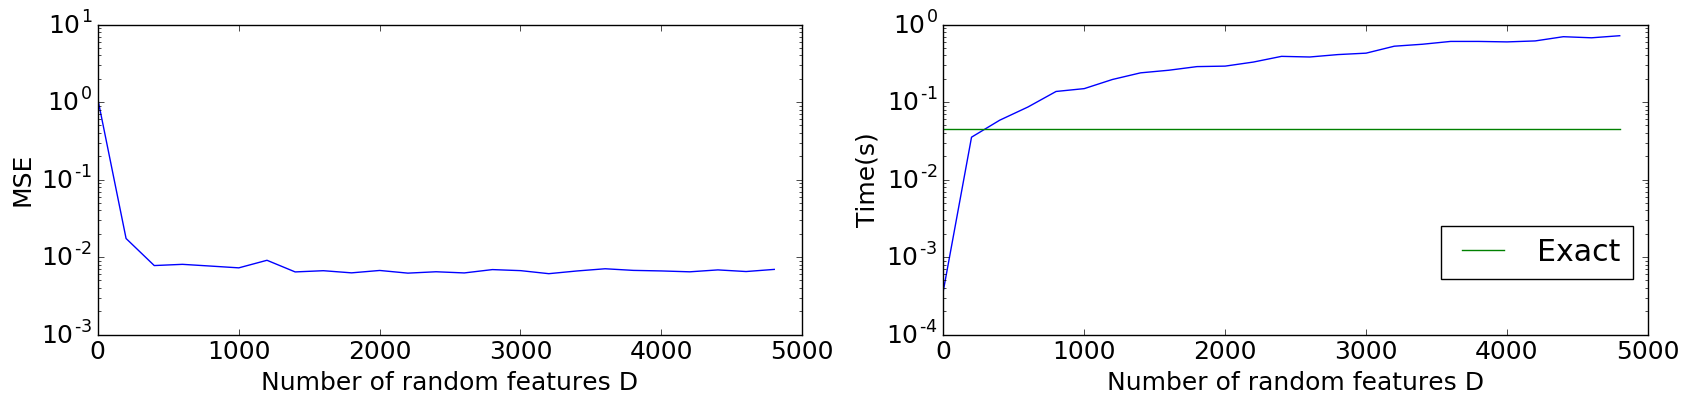

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,4))
mpl.rcParams.update({'font.size': 18})
for ax,data, ylabel in zip(axes,[errors,times],['MSE','Time(s)']):
    ax.plot(Ds, data)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Number of random features D")
    ax.set_yscale("log")
plt.plot(Ds, len(Ds)*[t_exact], label = "Exact")
plt.legend(bbox_to_anchor=[1,0.4])
plt.show()

# In the next notebooks:
Some experiments on real datasets ($gisette$, $usps$):

<a href="http://nbviewer.jupyter.org/github/hichamjanati/srf/tree/master/SRF-III.ipynb">

First experiments (step by step) </a> 

Extensive experiments of J. pennington et al., 2015. can be found here :

<a href="http://nbviewer.jupyter.org/github/hichamjanati/srf/tree/master/SRF-stats.ipynb">

Extensive experiments </a> (figures and tables of <a href="https://github.com/hichamjanati/srf/review.pdf"> my review </a>
